In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [32]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()

        # Define FS parameters (now as learnable parameters)
        self.h = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.d = nn.Parameter(torch.abs(torch.randn(num_params)))
        self.T = nn.Parameter(torch.randn(num_params))
        
        # Initializing parameters using uniform distribution similar to TensorFlow's setup
        # self.h = nn.Parameter(torch.FloatTensor(num_params).uniform_(-1, 0))
        # self.d = nn.Parameter(torch.FloatTensor(num_params).uniform_(-0.5, 1))
        # self.T = nn.Parameter(torch.FloatTensor(num_params).uniform_(-1, 1))
        
        # self.h = nn.Parameter(torch.randn(4) * 0.1)
        # self.d = nn.Parameter(torch.randn(4) * 0.1)
        # self.T = nn.Parameter(torch.randn(4) * 0.1)
        
        # Additional layers and activations
        # self.fc1 = nn.Linear(1, 10)  # First additional layer
        # self.fc2 = nn.Linear(10, 10) # Second additional layer
        # self.fc3 = nn.Linear(10, 1)
        # self.leaky_relu = nn.LeakyReLU(0.01)  # LeakyReLU activation

    def forward(self, x):
        v = x

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]
        
        # Additional processing with layers and activations
        # temp_out = temp_out.unsqueeze(-1)  # Ensure correct dimension for linear layers
        # temp_out = self.fc1(temp_out)
        # temp_out = self.leaky_relu(temp_out)
        # temp_out = self.fc2(temp_out)
        # temp_out = self.leaky_relu(temp_out)
        # temp_out = temp_out.squeeze()  # Flatten to match original dimension

        return temp_out

In [36]:
class FS(nn.Module):
    def __init__(self, normal_ts, extended_ts):
        super(FS, self).__init__()
        # Initialize parameters for both normal and extended timesteps
        self.h = nn.Parameter(torch.randn(max(normal_ts, extended_ts)) * 0.1)
        self.d = nn.Parameter(torch.randn(max(normal_ts, extended_ts)) * 0.1)
        self.T = nn.Parameter(torch.randn(max(normal_ts, extended_ts)) * 0.1)

    def forward(self, x):
        v = x.clone()  # 입력 x의 복사본을 생성하여 사용
        temp_out = torch.zeros_like(v)

        # Apply different timesteps based on the range of x
        for i in range(x.size(0)):
            current_v = v[i].clone()  # v[i]의 값을 복사하여 작업을 진행
            timesteps = 8 if -5 <= x[i] <= 0 else 4
            for t in range(timesteps):
                v_scaled = (current_v - self.T[t]) / (torch.abs(current_v) + 1)
                z = spike_function(v_scaled)
                temp_out[i] += z * self.d[t]
                current_v = current_v - z * self.h[t]  # Update without in-place operation

        return temp_out


Sigmoid

In [ ]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training data
x_train = torch.linspace(-5, 5, steps=100).unsqueeze(1)  # Input
y_train = sigmoid(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 100 epochs
    if epoch % 100 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Print final loss
print(f'Final Loss: {loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = sigmoid(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Sigmoid Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Sigmoid Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

Swish

Epoch 1/100000, Loss: 12.116032600402832
Epoch 101/100000, Loss: 3.0921177864074707
Epoch 201/100000, Loss: 1.5158673524856567
Epoch 301/100000, Loss: 1.0339614152908325
Epoch 401/100000, Loss: 0.8498733043670654
Epoch 501/100000, Loss: 0.7479312419891357
Epoch 601/100000, Loss: 0.6809237599372864
Epoch 701/100000, Loss: 0.6343074440956116
Epoch 801/100000, Loss: 0.6016263365745544
Epoch 901/100000, Loss: 0.5669693946838379
Epoch 1001/100000, Loss: 0.5341110229492188
Epoch 1101/100000, Loss: 0.5092685222625732
Epoch 1201/100000, Loss: 0.5035393238067627
Epoch 1301/100000, Loss: 0.49805545806884766
Epoch 1401/100000, Loss: 0.4912090599536896
Epoch 1501/100000, Loss: 0.4841677248477936
Epoch 1601/100000, Loss: 0.4773986041545868
Epoch 1701/100000, Loss: 0.47096017003059387
Epoch 1801/100000, Loss: 0.46496954560279846
Epoch 1901/100000, Loss: 0.4593135416507721
Epoch 2001/100000, Loss: 0.45393356680870056
Epoch 2101/100000, Loss: 0.4488537609577179
Epoch 2201/100000, Loss: 0.4439675807952

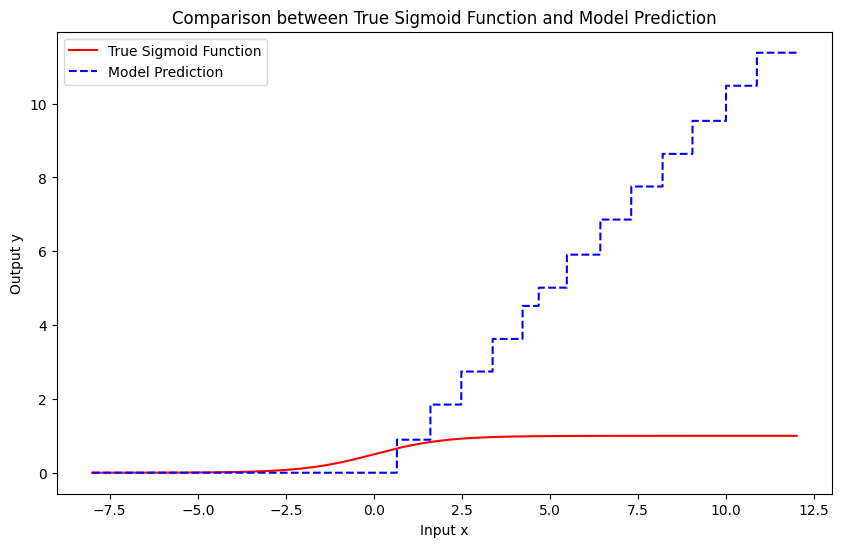

In [ ]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 100 epochs
    if epoch % 100 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Print final loss
print(f'Final Loss: {loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

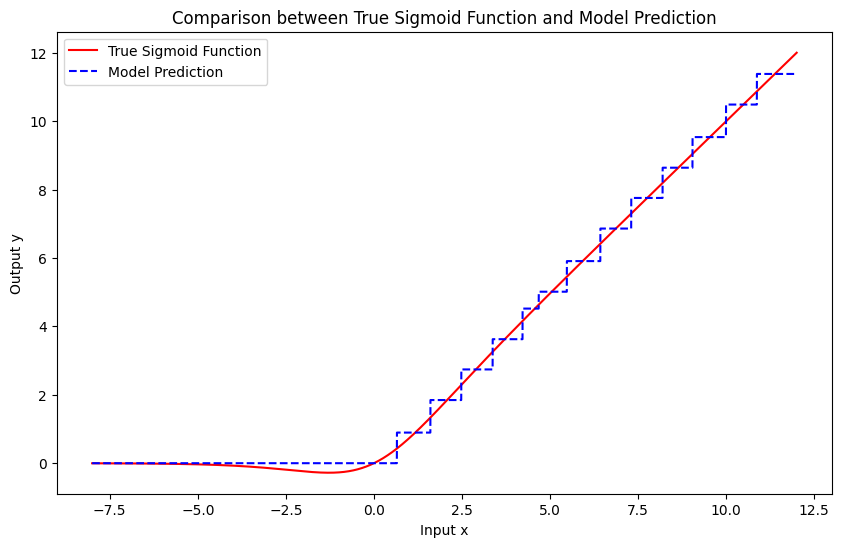

In [ ]:
# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

Epoch 1/100000, Loss: 6.302420139312744
Epoch 101/100000, Loss: 2.249626874923706
Epoch 201/100000, Loss: 1.4137758016586304
Epoch 301/100000, Loss: 1.0576354265213013
Epoch 401/100000, Loss: 0.8401432633399963
Epoch 501/100000, Loss: 0.6991365551948547
Epoch 601/100000, Loss: 0.6034650206565857
Epoch 701/100000, Loss: 0.5363655090332031
Epoch 801/100000, Loss: 0.4876675009727478
Epoch 901/100000, Loss: 0.45118725299835205
Epoch 1001/100000, Loss: 0.4229888319969177
Epoch 1101/100000, Loss: 0.40056437253952026
Epoch 1201/100000, Loss: 0.3763066828250885
Epoch 1301/100000, Loss: 0.35749778151512146
Epoch 1401/100000, Loss: 0.3404557704925537
Epoch 1501/100000, Loss: 0.325036883354187
Epoch 1601/100000, Loss: 0.3119795024394989
Epoch 1701/100000, Loss: 0.30245551466941833
Epoch 1801/100000, Loss: 0.2953116297721863
Epoch 1901/100000, Loss: 0.28684723377227783
Epoch 2001/100000, Loss: 0.2779542803764343
Epoch 2101/100000, Loss: 0.2693919241428375
Epoch 2201/100000, Loss: 0.261354595422744

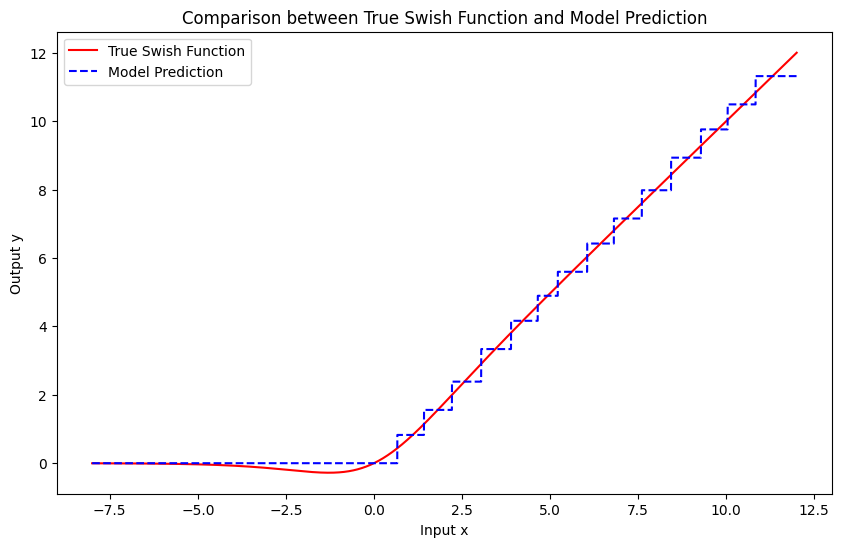

In [7]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Adjusting training data distribution
x_train = torch.cat((
    torch.linspace(-8, -5, steps=20000),  # Less samples in -8 to -5
    torch.linspace(-5, 2, steps=60000),   # More samples in -5 to 2
    torch.linspace(2, 12, steps=20000)    # Less samples in 2 to 12
)).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Adjusting loss function with weights
#weights = torch.ones_like(y_train)
# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(x_train)
weights[(x_train > -5) & (x_train < 2)] = 5

torch.autograd.set_detect_anomaly(True)

# Training loop
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 100 epochs
    if epoch % 100 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Print final loss
print(f'Final Loss: {loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

손실 함수 가중치 적용, Adam 변경(세밀한 조정을 위해)

Epoch 1/100000, Weighted Loss: 24.78717041015625
Epoch 1001/100000, Weighted Loss: 7.304193019866943
Epoch 2001/100000, Weighted Loss: 2.599386692047119
Epoch 3001/100000, Weighted Loss: 1.262309193611145
Epoch 4001/100000, Weighted Loss: 0.7547983527183533
Epoch 5001/100000, Weighted Loss: 0.5805026292800903
Epoch 6001/100000, Weighted Loss: 0.5753011107444763
Epoch 7001/100000, Weighted Loss: 0.5450244545936584
Epoch 8001/100000, Weighted Loss: 0.4269455373287201
Epoch 9001/100000, Weighted Loss: 0.32397353649139404
Epoch 10001/100000, Weighted Loss: 0.2465100735425949
Epoch 11001/100000, Weighted Loss: 0.23290781676769257
Epoch 12001/100000, Weighted Loss: 0.21108511090278625
Epoch 13001/100000, Weighted Loss: 0.18769541382789612
Epoch 14001/100000, Weighted Loss: 0.16812792420387268
Epoch 15001/100000, Weighted Loss: 0.1642182469367981
Epoch 16001/100000, Weighted Loss: 0.16420820355415344
Epoch 17001/100000, Weighted Loss: 0.16420820355415344
Epoch 18001/100000, Weighted Loss: 0.1

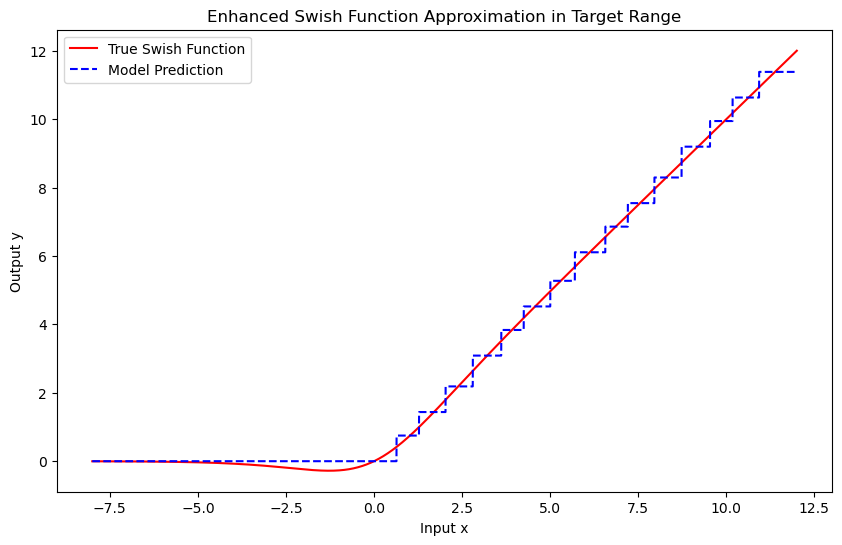

In [6]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='none')  # Use 'none' to manually apply weights later
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Adjusting training data distribution
x_train = torch.cat((
    torch.linspace(-8, -5, steps=20000),  # Less samples in -8 to -5
    torch.linspace(-5, 2, steps=60000),   # More samples in -5 to 2
    torch.linspace(2, 12, steps=20000)    # Less samples in 2 to 12
)).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(y_train)
weights[x_train >= -5] *= 5  # Increase weight for -5 to 2 range

# Training loop
epochs = 100000  # Reduced number of epochs for practicality
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train) * weights  # Apply weights
    weighted_loss = loss.mean()
    weighted_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Weighted Loss: {weighted_loss.item()}')

# Print final loss
print(f'Final Loss: {weighted_loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Enhanced Swish Function Approximation in Target Range')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

2트

Epoch 1/100000, Weighted Loss: 43.9492301940918
Epoch 1001/100000, Weighted Loss: 14.847431182861328
Epoch 2001/100000, Weighted Loss: 5.160451412200928
Epoch 3001/100000, Weighted Loss: 2.131978988647461
Epoch 4001/100000, Weighted Loss: 1.1235543489456177
Epoch 5001/100000, Weighted Loss: 0.7256295084953308
Epoch 6001/100000, Weighted Loss: 0.576880693435669
Epoch 7001/100000, Weighted Loss: 0.5294046401977539
Epoch 8001/100000, Weighted Loss: 0.4605955481529236
Epoch 9001/100000, Weighted Loss: 0.3627080023288727
Epoch 10001/100000, Weighted Loss: 0.2999875247478485
Epoch 11001/100000, Weighted Loss: 0.2476036101579666
Epoch 12001/100000, Weighted Loss: 0.24007847905158997
Epoch 13001/100000, Weighted Loss: 0.214621901512146
Epoch 14001/100000, Weighted Loss: 0.19062694907188416
Epoch 15001/100000, Weighted Loss: 0.17207294702529907
Epoch 16001/100000, Weighted Loss: 0.16425208747386932
Epoch 17001/100000, Weighted Loss: 0.16421447694301605
Epoch 18001/100000, Weighted Loss: 0.16421

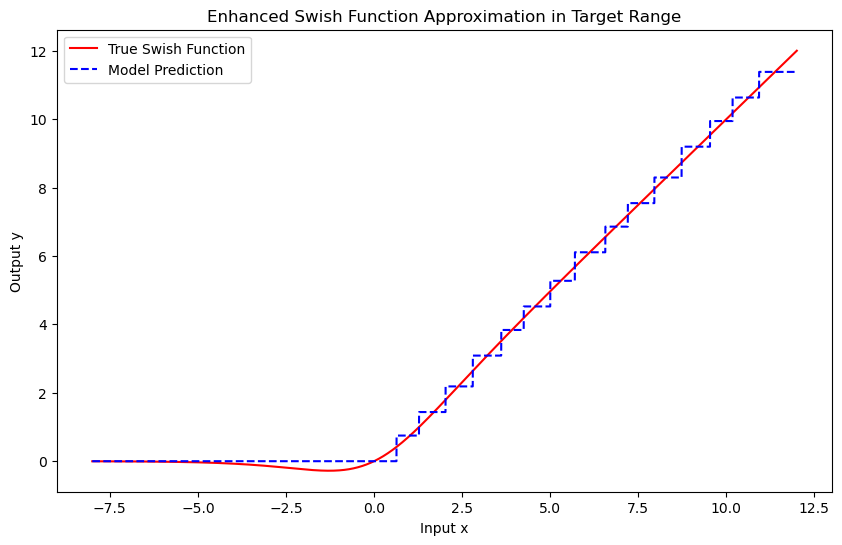

In [8]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='none')  # Use 'none' to manually apply weights later
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Adjusting training data distribution
x_train = torch.cat((
    torch.linspace(-8, -5, steps=20000),  # Less samples in -8 to -5
    torch.linspace(-5, 2, steps=60000),   # More samples in -5 to 2
    torch.linspace(2, 12, steps=20000)    # Less samples in 2 to 12
)).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(y_train)
weights[x_train >= -5] *= 5  # Increase weight for -5 to 2 range

# Training loop
epochs = 100000  # Reduced number of epochs for practicality
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train) * weights  # Apply weights
    weighted_loss = loss.mean()
    weighted_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Weighted Loss: {weighted_loss.item()}')

# Print final loss
print(f'Final Loss: {weighted_loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Enhanced Swish Function Approximation in Target Range')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

Epoch 1/20000, Weighted Loss: 92.61299133300781
Epoch 1001/20000, Weighted Loss: 29.602657318115234
Epoch 2001/20000, Weighted Loss: 9.882036209106445
Epoch 3001/20000, Weighted Loss: 4.2459893226623535
Epoch 4001/20000, Weighted Loss: 2.4753410816192627
Epoch 5001/20000, Weighted Loss: 1.656089425086975
Epoch 6001/20000, Weighted Loss: 1.1232709884643555
Epoch 7001/20000, Weighted Loss: 0.8454459309577942
Epoch 8001/20000, Weighted Loss: 0.7521985769271851
Epoch 9001/20000, Weighted Loss: 0.6173697710037231
Epoch 10001/20000, Weighted Loss: 0.48331788182258606
Epoch 11001/20000, Weighted Loss: 0.346648633480072
Epoch 12001/20000, Weighted Loss: 0.32236990332603455
Epoch 13001/20000, Weighted Loss: 0.29343143105506897
Epoch 14001/20000, Weighted Loss: 0.2617286145687103
Epoch 15001/20000, Weighted Loss: 0.2258475422859192
Epoch 16001/20000, Weighted Loss: 0.199745774269104
Epoch 17001/20000, Weighted Loss: 0.19910140335559845
Epoch 18001/20000, Weighted Loss: 0.1991167515516281
Epoch 1

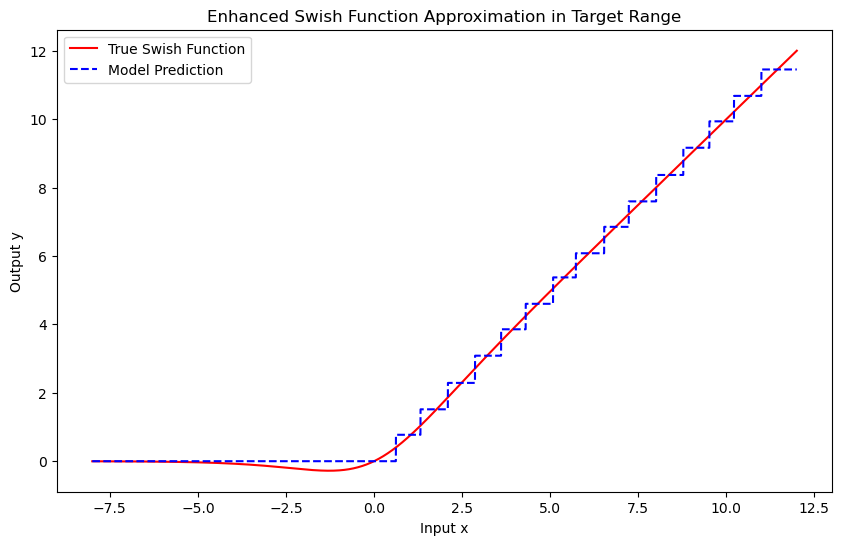

In [33]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='none')  # Use 'none' to manually apply weights later
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Adjusting training data distribution
x_train = torch.linspace(-8, 12, 100000).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(y_train)
weights[x_train >= -5] *= 5  # Increase weight for -5 to 2 range

# Training loop
epochs = 20000  # Reduced number of epochs for practicality
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train) * weights  # Apply weights
    weighted_loss = loss.mean()
    weighted_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Weighted Loss: {weighted_loss.item()}')

# Print final loss
print(f'Final Loss: {weighted_loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Enhanced Swish Function Approximation in Target Range')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

타임스텝을 8로 했을 때 실험

Epoch 1/30000, Weighted Loss: 14.449787139892578
Epoch 1001/30000, Weighted Loss: 1.1251764297485352
Epoch 2001/30000, Weighted Loss: 0.4154408574104309
Epoch 3001/30000, Weighted Loss: 0.35662832856178284
Epoch 4001/30000, Weighted Loss: 0.22180937230587006
Epoch 5001/30000, Weighted Loss: 0.0994267612695694
Epoch 6001/30000, Weighted Loss: 0.07295108586549759
Epoch 7001/30000, Weighted Loss: 0.06495673209428787
Epoch 8001/30000, Weighted Loss: 0.05784117802977562
Epoch 9001/30000, Weighted Loss: 0.04920639470219612
Epoch 10001/30000, Weighted Loss: 0.03954121470451355
Epoch 11001/30000, Weighted Loss: 0.03439933806657791
Epoch 12001/30000, Weighted Loss: 0.027772311121225357
Epoch 13001/30000, Weighted Loss: 0.024080602452158928
Epoch 14001/30000, Weighted Loss: 0.02288386970758438
Epoch 15001/30000, Weighted Loss: 0.022839076817035675
Epoch 16001/30000, Weighted Loss: 0.021329393610358238
Epoch 17001/30000, Weighted Loss: 0.020114028826355934
Epoch 18001/30000, Weighted Loss: 0.0200

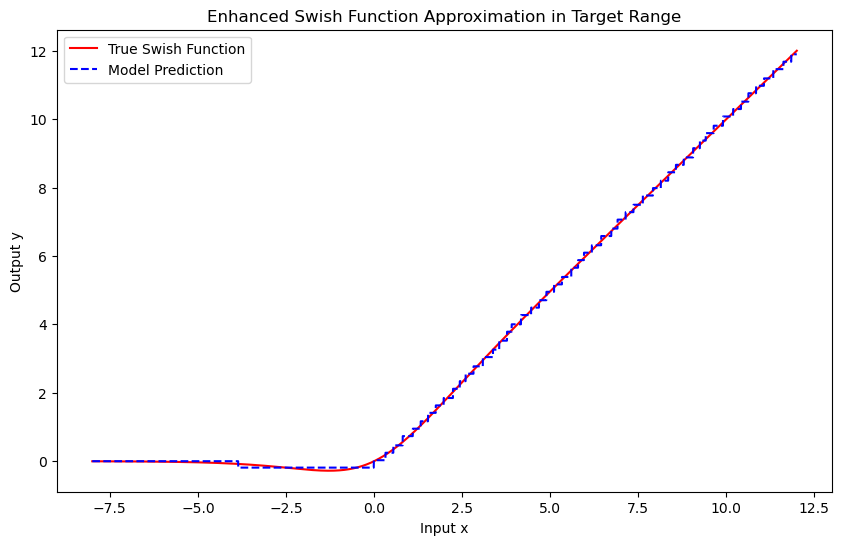

In [25]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='none')  # Use 'none' to manually apply weights later
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Adjusting training data distribution
x_train = torch.cat((
    torch.linspace(-8, -5, steps=20000),  # Less samples in -8 to -5
    torch.linspace(-5, 2, steps=60000),   # More samples in -5 to 2
    torch.linspace(2, 12, steps=20000)    # Less samples in 2 to 12
)).unsqueeze(1)
y_train = swish(x_train)  # Target value

# Weighting the loss function more heavily on -5 to 2 range
weights = torch.ones_like(y_train)
weights[x_train >= -5] *= 5  # Increase weight for -5 to 2 range

# Training loop
epochs = 30000  # Reduced number of epochs for practicality
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train) * weights  # Apply weights
    weighted_loss = loss.mean()
    weighted_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Weighted Loss: {weighted_loss.item()}')

# Print final loss
print(f'Final Loss: {weighted_loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Enhanced Swish Function Approximation in Target Range')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

똑같이 만든 코드

In [4]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)  # Input
y_train = swish(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 100 epochs
    if epoch % 100 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Print final loss
print(f'Final Loss: {loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = swish(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Swish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Swish Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

Epoch 1/100000, Loss: 18.979814529418945
Epoch 101/100000, Loss: 16.845630645751953
Epoch 201/100000, Loss: 14.915535926818848
Epoch 301/100000, Loss: 13.195725440979004
Epoch 401/100000, Loss: 11.682021141052246
Epoch 501/100000, Loss: 10.36204719543457
Epoch 601/100000, Loss: 9.216498374938965
Epoch 701/100000, Loss: 8.222298622131348
Epoch 801/100000, Loss: 7.354760646820068
Epoch 901/100000, Loss: 6.594542026519775
Epoch 1001/100000, Loss: 5.902812480926514
Epoch 1101/100000, Loss: 5.2860870361328125
Epoch 1201/100000, Loss: 4.7339982986450195
Epoch 1301/100000, Loss: 4.240232944488525
Epoch 1401/100000, Loss: 3.7998125553131104
Epoch 1501/100000, Loss: 3.4080348014831543
Epoch 1601/100000, Loss: 3.0605034828186035
Epoch 1701/100000, Loss: 2.7555110454559326
Epoch 1801/100000, Loss: 2.486192226409912
Epoch 1901/100000, Loss: 2.246509552001953
Epoch 2001/100000, Loss: 2.034736156463623
Epoch 2101/100000, Loss: 1.8488823175430298
Epoch 2201/100000, Loss: 1.6847704648971558
Epoch 2301

KeyboardInterrupt: 

GeLU

In [ ]:
# Instantiate model and initial setup
input_dim = 1
k_neurons = 16  # Select arbitrary number of neurons
num_params = 16  # Select arbitrary number of parameters
model = FS(input_dim, k_neurons, num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training data
x_train = torch.linspace(-10, 10, steps=100).unsqueeze(1)  # Input
y_train = gelu(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 100 epochs
    if epoch % 100 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

# Print final loss
print(f'Final Loss: {loss.item()}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = gelu(x_train).squeeze()

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True GeLU Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True GeLU Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

Epoch 1/100000, Loss: 16.04350471496582
Epoch 1001/100000, Loss: 0.03995278477668762
Epoch 2001/100000, Loss: 0.01932363584637642
Epoch 3001/100000, Loss: 0.016070056706666946
Epoch 4001/100000, Loss: 0.01664649322628975
Epoch 5001/100000, Loss: 0.013625516556203365
Epoch 6001/100000, Loss: 0.012381268665194511
Epoch 7001/100000, Loss: 0.011113815009593964
Epoch 8001/100000, Loss: 0.010645362548530102
Epoch 9001/100000, Loss: 0.013937012292444706
Epoch 10001/100000, Loss: 0.0089075593277812
Epoch 11001/100000, Loss: 0.010526244528591633
Epoch 12001/100000, Loss: 0.009391916915774345
Epoch 13001/100000, Loss: 0.010111148469150066
Epoch 14001/100000, Loss: 0.008871813304722309
Epoch 15001/100000, Loss: 0.009034411981701851
Epoch 16001/100000, Loss: 0.008882645517587662
Epoch 17001/100000, Loss: 0.009219828061759472
Epoch 18001/100000, Loss: 0.008641485124826431
Epoch 19001/100000, Loss: 0.010022853501141071
Epoch 20001/100000, Loss: 0.006460567004978657
Epoch 21001/100000, Loss: 0.005467

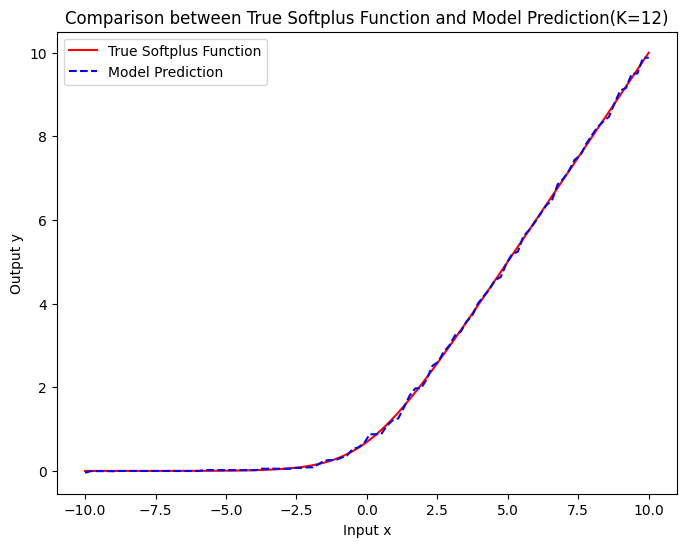

In [ ]:
# Instantiate model and initial setup
input_dim = 1
k_neurons = 12  # Select arbitrary number of neurons
num_params = 12  # Select arbitrary number of parameters
model = FS(input_dim, k_neurons, num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training data
x_train = torch.linspace(-10, 10, steps=100).unsqueeze(1)  # Input
y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

loss_values = []

# Training loop
epochs = 100000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Softplus Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Softplus Function and Model Prediction(K=12)')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

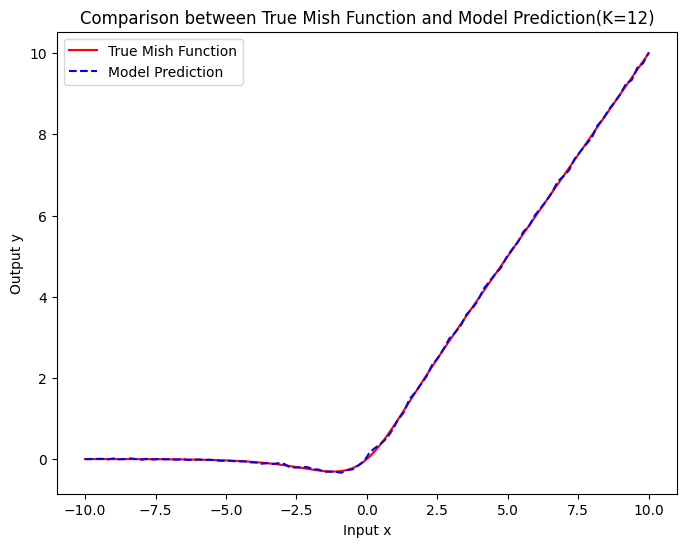

In [ ]:
# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = mish(x_train).squeeze()

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Mish Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Mish Function and Model Prediction(K=12)')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()